# Cost Impact Mapping — From Price Scenarios to Cost Distributions

This notebook maps exogenously defined energy price scenarios into cost outcomes
using a transparent and parametric cost function.

The objective is to quantify how different price stress profiles translate into
heterogeneous cost risk for an energy-exposed firm.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_PATH = ROOT / "data" / "processed" / "brent_clean_monthly.csv"


In [9]:
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df.head()


,Date,price
0,2000-01-01,25.633333
1,2000-02-01,28.030476
2,2000-03-01,27.494348
3,2000-04-01,23.153500
4,2000-05-01,27.805217


In [10]:
stress_periods = {
    "GFC_2008": ("2007-01-01", "2009-12-01"),
    "Oil_Glut_2014": ("2014-01-01", "2016-12-01"),
    "COVID_2020": ("2019-01-01", "2021-12-01"),
    "Energy_Crisis_2022": ("2021-01-01", "2023-12-01"),
}


In [11]:
def cost_function(price, beta=1.0):
    """
    Linear cost mapping:
    Cost_t = beta * Price_t
    """
    return beta * price


In [12]:
beta = 1.0  # normalized exposure

cost_scenarios = {}

for name, (start, end) in stress_periods.items():
    mask = (df["Date"] >= start) & (df["Date"] <= end)
    sub = df.loc[mask].copy()
    
    sub["cost"] = cost_function(sub["price"], beta=beta)
    cost_scenarios[name] = sub


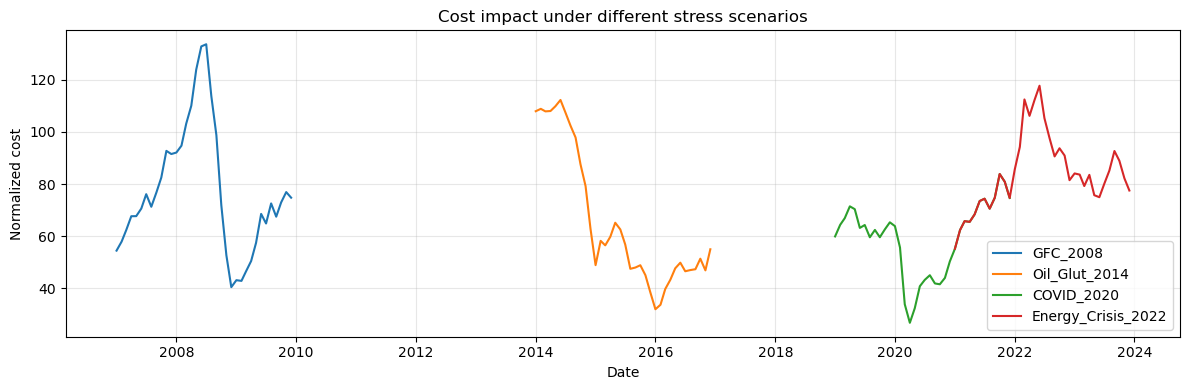

In [13]:
plt.figure(figsize=(12,4))

for name, sub in cost_scenarios.items():
    plt.plot(sub["Date"], sub["cost"], label=name)

plt.title("Cost impact under different stress scenarios")
plt.xlabel("Date")
plt.ylabel("Normalized cost")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Interpretation of cost paths under historical stress scenarios

The figure shows the evolution of **normalized costs** under different historical stress episodes, obtained by applying a linear cost mapping:

The cost is given by $\mathrm{Cost}_t = \beta \cdot \mathrm{Price}_t$, with $\beta = 1$.

At this stage, costs are directly proportional to the underlying Brent price and therefore reflect **pure price-driven exposure**, without firm-specific adjustments (e.g. volumes, hedging, or pass-through mechanisms).

### Key observations

- **Heterogeneity of stress dynamics**  
  Although all episodes span a comparable time horizon, their cost trajectories differ substantially in shape, amplitude, and persistence.  
  The Global Financial Crisis (2008) and the 2022 Energy Crisis are characterized by sharp upward spikes, while the 2014 Oil Glut and COVID-19 episodes exhibit deep and prolonged cost drawdowns.

- **Asymmetry between upside and downside risk**  
  Some scenarios are dominated by extreme cost increases (supply-driven stress), while others primarily expose downside risk (demand collapse).  
  This highlights that stress is not only about volatility, but also about the **direction and persistence** of cost shocks.

- **Temporal concentration of risk**  
  Stress episodes differ in how quickly costs adjust and recover. Short-lived but violent shocks (e.g. COVID-2020) contrast with longer-lasting regimes (e.g. Energy Crisis 2022), which is crucial for budgeting and liquidity planning.

### Interpretation and scope

These results should be interpreted as **scenario-based stress projections**, not as forecasts.  
The framework does not assume a unique data-generating process for prices, but treats historical episodes as **structured exogenous stress inputs** propagated through a deterministic cost mapping.

At this stage, the analysis provides a **baseline cost-risk representation**, intended to support comparison across scenarios rather than firm-level valuation.

### Next steps

In the next stage, the cost function can be extended to incorporate:

- explicit exposure levels (e.g. physical consumption),
- smoothing or lag effects (procurement and contracts),
- partial pass-through and hedging assumptions.

These extensions will allow the same scenario structure to generate **firm-level cost risk metrics** rather than normalized price-based proxies.


### Summary metrics across stress scenarios (normalized costs)


In [14]:
# Micro-summary table for scenario comparison (normalized costs)
summary_rows = []

for scenario, sub in cost_scenarios.items():
    cost = sub["cost"].dropna().to_numpy()

    peak_cost = float(np.max(cost))
    min_cost  = float(np.min(cost))
    duration_months = int(len(cost))

    # Peak-to-trough drawdown expressed as %
    max_drawdown_pct = (min_cost / peak_cost - 1.0) * 100.0

    summary_rows.append({
        "scenario": scenario,
        "duration_months": duration_months,
        "peak_cost": peak_cost,
        "min_cost": min_cost,
        "max_drawdown_pct": max_drawdown_pct
    })

cost_summary = pd.DataFrame(summary_rows).sort_values("max_drawdown_pct").reset_index(drop=True)

# Pretty display
cost_summary.style.format({
    "peak_cost": "{:.2f}",
    "min_cost": "{:.2f}",
    "max_drawdown_pct": "{:.1f}"
})


,scenario,duration_months,peak_cost,min_cost,max_drawdown_pct
0,Oil_Glut_2014,36,112.24,32.05,-71.4
1,GFC_2008,36,133.59,40.51,-69.7
2,COVID_2020,36,83.87,26.85,-68.0
3,Energy_Crisis_2022,36,117.69,55.22,-53.1


In [15]:
# Save summary to processed data for reuse (e.g., Notebook 04)
out_path = ROOT / "data" / "processed" / "cost_summary_normalized.csv"
cost_summary.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: /Users/gianlucaaddorisio/Desktop/Progetti/energy-cost-scenario-analytics/data/processed/cost_summary_normalized.csv


### Interpretation of normalized cost risk across scenarios

The summary table highlights substantial heterogeneity in cost risk profiles across historical stress scenarios.
Episodes characterized by prolonged demand-driven downturns (e.g. Oil Glut 2014, COVID-19) exhibit the largest peak-to-trough drawdowns, while supply-driven crises (e.g. GFC 2008, Energy Crisis 2022) are dominated by sharp upside cost spikes.

Importantly, scenarios with similar duration can generate markedly different cost dynamics, underscoring that risk is driven not only by magnitude but also by the **path and persistence** of price movements.

At this stage, costs are normalized and reflect pure price exposure.
In subsequent analysis, the same framework will be extended to incorporate explicit exposure levels and firm-specific assumptions in order to derive economically meaningful cost risk metrics.
